<a href="https://colab.research.google.com/github/bhkpriyanka/EVA4/blob/master/Week7/Approach2/S7_FinalCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

In [3]:
#print(torch.cuda.is_available())
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
print("CUDA current device:", torch.cuda.current_device())
print("CUDA device name:", torch.cuda.get_device_name(0)) 

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True
CUDA current device: 0
CUDA device name: Tesla P100-PCIE-16GB


In [4]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.RandomRotation((-3.0, 3.0)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     #transforms.RandomRotation((-3.0, 3.0))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([3, 32, 32])
64
plane   dog  deer  deer


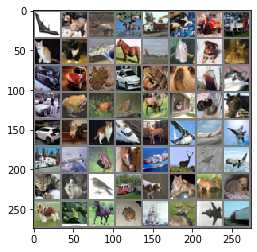

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images[0].shape)
print(len(images))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))



In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 32

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1 ,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.15)
        ) # output_size = 32
        '''self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            #nn.Dropout(0.01)
        ) # output_size = 2'''
        self.dwsconv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1,groups= 64, bias=False),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.25)
        ) # output_size = 32

        # TRANSITION BLOCK 1
        self.conv1x1_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16

         # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 16
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.15)
        ) # output_size = 16
        '''self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            #nn.Dropout(0.01)
        ) # output_size = 2'''
        self.dwsconv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1,groups= 64, bias=False),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.25)
        ) # output_size = 16


        # TRANSITION BLOCK 2
        self.conv1x1_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8

        # CONVOLUTION BLOCK 3
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1,dilation=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 8
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=2,dilation=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.15)
        ) # output_size = 8
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=2,dilation=2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.25)
        ) # output_size = 8


        # TRANSITION BLOCK 3
        self.conv1x1_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8
        self.pool3 = nn.MaxPool2d(2, 2) # output_size = 4

         # CONVOLUTION BLOCK 4
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(0.01)
        ) # output_size = 4

               
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.fcn = nn.Sequential(
            #nn.Linear(in_features=64, out_features=10, bias=False)
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) 

        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        #x = self.convblock3(x)
        x = self.dwsconv1(x)
        x = self.conv1x1_1(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        #x = self.convblock6(x)
        x = self.dwsconv2(x)
        x = self.conv1x1_2(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.conv1x1_3(x)
        x = self.pool3(x)
        x = self.convblock10(x)
        #x = self.convblock11(x)
        
        x = self.gap(x)  

        x = self.fcn(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]             576
           Conv2d-10          [-1, 128, 32, 32]           8,320
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
          Dropout-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=12, gamma=0.1)

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)
    #scheduler.step()
    print('')

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.3288702964782715 Batch_id=781 Accuracy=43.05: 100%|██████████| 782/782 [00:17<00:00, 45.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1727, Accuracy: 5759/10000 (57.59%)


EPOCH: 2


Loss=1.23783540725708 Batch_id=781 Accuracy=59.24: 100%|██████████| 782/782 [00:17<00:00, 44.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0931, Accuracy: 6075/10000 (60.75%)


EPOCH: 3


Loss=1.0253127813339233 Batch_id=781 Accuracy=65.16: 100%|██████████| 782/782 [00:16<00:00, 46.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9635, Accuracy: 6676/10000 (66.76%)


EPOCH: 4


Loss=0.776344895362854 Batch_id=781 Accuracy=69.16: 100%|██████████| 782/782 [00:17<00:00, 45.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9253, Accuracy: 6777/10000 (67.77%)


EPOCH: 5


Loss=0.9460577964782715 Batch_id=781 Accuracy=71.67: 100%|██████████| 782/782 [00:17<00:00, 45.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7829, Accuracy: 7287/10000 (72.87%)


EPOCH: 6


Loss=0.45945531129837036 Batch_id=781 Accuracy=73.99: 100%|██████████| 782/782 [00:16<00:00, 49.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7669, Accuracy: 7316/10000 (73.16%)


EPOCH: 7


Loss=0.758027195930481 Batch_id=781 Accuracy=75.60: 100%|██████████| 782/782 [00:16<00:00, 47.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6694, Accuracy: 7640/10000 (76.40%)


EPOCH: 8


Loss=0.5970994234085083 Batch_id=781 Accuracy=76.88: 100%|██████████| 782/782 [00:17<00:00, 47.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6813, Accuracy: 7641/10000 (76.41%)


EPOCH: 9


Loss=0.4931573271751404 Batch_id=781 Accuracy=77.82: 100%|██████████| 782/782 [00:16<00:00, 47.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6522, Accuracy: 7763/10000 (77.63%)


EPOCH: 10


Loss=1.63006591796875 Batch_id=781 Accuracy=78.91: 100%|██████████| 782/782 [00:16<00:00, 46.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6449, Accuracy: 7783/10000 (77.83%)


EPOCH: 11


Loss=1.085699200630188 Batch_id=781 Accuracy=79.58: 100%|██████████| 782/782 [00:16<00:00, 46.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5676, Accuracy: 8018/10000 (80.18%)


EPOCH: 12


Loss=0.6034514904022217 Batch_id=781 Accuracy=80.47: 100%|██████████| 782/782 [00:16<00:00, 47.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6492, Accuracy: 7832/10000 (78.32%)


EPOCH: 13


Loss=0.4304426610469818 Batch_id=781 Accuracy=81.12: 100%|██████████| 782/782 [00:16<00:00, 46.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6084, Accuracy: 7899/10000 (78.99%)


EPOCH: 14


Loss=0.6486039161682129 Batch_id=781 Accuracy=81.67: 100%|██████████| 782/782 [00:16<00:00, 47.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5689, Accuracy: 8114/10000 (81.14%)


EPOCH: 15


Loss=0.6583743095397949 Batch_id=781 Accuracy=82.20: 100%|██████████| 782/782 [00:16<00:00, 46.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6281, Accuracy: 7887/10000 (78.87%)


EPOCH: 16


Loss=0.8067660331726074 Batch_id=781 Accuracy=82.33: 100%|██████████| 782/782 [00:16<00:00, 47.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5707, Accuracy: 8108/10000 (81.08%)


EPOCH: 17


Loss=0.5612273216247559 Batch_id=781 Accuracy=82.94: 100%|██████████| 782/782 [00:16<00:00, 47.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5571, Accuracy: 8137/10000 (81.37%)


EPOCH: 18


Loss=0.6795541048049927 Batch_id=781 Accuracy=83.35: 100%|██████████| 782/782 [00:17<00:00, 45.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5696, Accuracy: 8119/10000 (81.19%)


EPOCH: 19


Loss=0.2642297148704529 Batch_id=781 Accuracy=83.36: 100%|██████████| 782/782 [00:16<00:00, 46.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5459, Accuracy: 8129/10000 (81.29%)


EPOCH: 20


Loss=0.5610755085945129 Batch_id=781 Accuracy=83.65: 100%|██████████| 782/782 [00:16<00:00, 47.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5380, Accuracy: 8158/10000 (81.58%)


EPOCH: 21


Loss=0.5118178129196167 Batch_id=781 Accuracy=84.34: 100%|██████████| 782/782 [00:18<00:00, 43.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5628, Accuracy: 8146/10000 (81.46%)


EPOCH: 22


Loss=0.23132795095443726 Batch_id=781 Accuracy=84.48: 100%|██████████| 782/782 [00:17<00:00, 44.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5441, Accuracy: 8188/10000 (81.88%)


EPOCH: 23


Loss=0.7960072755813599 Batch_id=781 Accuracy=84.86: 100%|██████████| 782/782 [00:17<00:00, 44.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5339, Accuracy: 8248/10000 (82.48%)


EPOCH: 24


Loss=0.18330658972263336 Batch_id=781 Accuracy=84.90: 100%|██████████| 782/782 [00:17<00:00, 43.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5090, Accuracy: 8314/10000 (83.14%)


EPOCH: 25


Loss=0.10724993050098419 Batch_id=781 Accuracy=85.17: 100%|██████████| 782/782 [00:17<00:00, 44.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5607, Accuracy: 8143/10000 (81.43%)


EPOCH: 26


Loss=0.3596478998661041 Batch_id=781 Accuracy=85.45: 100%|██████████| 782/782 [00:17<00:00, 44.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5025, Accuracy: 8317/10000 (83.17%)


EPOCH: 27


Loss=0.12832008302211761 Batch_id=781 Accuracy=85.80: 100%|██████████| 782/782 [00:18<00:00, 43.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5905, Accuracy: 8040/10000 (80.40%)


EPOCH: 28


Loss=0.33849045634269714 Batch_id=781 Accuracy=86.03: 100%|██████████| 782/782 [00:17<00:00, 45.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5254, Accuracy: 8258/10000 (82.58%)


EPOCH: 29


Loss=0.2718861699104309 Batch_id=781 Accuracy=86.12: 100%|██████████| 782/782 [00:17<00:00, 43.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5157, Accuracy: 8307/10000 (83.07%)


EPOCH: 30


Loss=1.0646591186523438 Batch_id=781 Accuracy=86.36: 100%|██████████| 782/782 [00:17<00:00, 43.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6261, Accuracy: 8040/10000 (80.40%)


EPOCH: 31


Loss=0.6631603240966797 Batch_id=781 Accuracy=86.40: 100%|██████████| 782/782 [00:17<00:00, 45.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5828, Accuracy: 8074/10000 (80.74%)


EPOCH: 32


Loss=0.2928909361362457 Batch_id=781 Accuracy=86.70: 100%|██████████| 782/782 [00:17<00:00, 44.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5457, Accuracy: 8200/10000 (82.00%)


EPOCH: 33


Loss=0.2423020899295807 Batch_id=781 Accuracy=86.90: 100%|██████████| 782/782 [00:18<00:00, 43.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5000, Accuracy: 8359/10000 (83.59%)


EPOCH: 34


Loss=0.24381929636001587 Batch_id=781 Accuracy=87.14: 100%|██████████| 782/782 [00:17<00:00, 45.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5354, Accuracy: 8227/10000 (82.27%)


EPOCH: 35


Loss=0.4693596661090851 Batch_id=781 Accuracy=87.39: 100%|██████████| 782/782 [00:17<00:00, 45.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5335, Accuracy: 8294/10000 (82.94%)


EPOCH: 36


Loss=0.3061733543872833 Batch_id=781 Accuracy=87.45: 100%|██████████| 782/782 [00:16<00:00, 46.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5042, Accuracy: 8350/10000 (83.50%)


EPOCH: 37


Loss=0.6068733930587769 Batch_id=781 Accuracy=87.54: 100%|██████████| 782/782 [00:16<00:00, 47.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5508, Accuracy: 8266/10000 (82.66%)


EPOCH: 38


Loss=0.8090766668319702 Batch_id=781 Accuracy=87.70: 100%|██████████| 782/782 [00:17<00:00, 45.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5191, Accuracy: 8338/10000 (83.38%)


EPOCH: 39


Loss=1.1188251972198486 Batch_id=781 Accuracy=87.59: 100%|██████████| 782/782 [00:16<00:00, 47.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5306, Accuracy: 8298/10000 (82.98%)


EPOCH: 40


Loss=0.4699075222015381 Batch_id=781 Accuracy=88.06: 100%|██████████| 782/782 [00:16<00:00, 46.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5393, Accuracy: 8259/10000 (82.59%)


EPOCH: 41


Loss=0.32006216049194336 Batch_id=781 Accuracy=87.85: 100%|██████████| 782/782 [00:16<00:00, 49.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5225, Accuracy: 8337/10000 (83.37%)


EPOCH: 42


Loss=1.0508748292922974 Batch_id=781 Accuracy=87.91: 100%|██████████| 782/782 [00:16<00:00, 52.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5060, Accuracy: 8388/10000 (83.88%)


EPOCH: 43


Loss=0.44813936948776245 Batch_id=781 Accuracy=88.27: 100%|██████████| 782/782 [00:17<00:00, 45.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5183, Accuracy: 8328/10000 (83.28%)


EPOCH: 44


Loss=0.22893428802490234 Batch_id=781 Accuracy=88.41: 100%|██████████| 782/782 [00:16<00:00, 46.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4592, Accuracy: 8517/10000 (85.17%)


EPOCH: 45


Loss=0.38209083676338196 Batch_id=781 Accuracy=88.71: 100%|██████████| 782/782 [00:16<00:00, 51.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5094, Accuracy: 8417/10000 (84.17%)


EPOCH: 46


Loss=1.144323706626892 Batch_id=781 Accuracy=88.59: 100%|██████████| 782/782 [00:16<00:00, 46.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5460, Accuracy: 8274/10000 (82.74%)


EPOCH: 47


Loss=0.46787241101264954 Batch_id=781 Accuracy=88.66: 100%|██████████| 782/782 [00:16<00:00, 50.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4932, Accuracy: 8458/10000 (84.58%)


EPOCH: 48


Loss=0.3335227966308594 Batch_id=781 Accuracy=89.08: 100%|██████████| 782/782 [00:16<00:00, 47.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5456, Accuracy: 8278/10000 (82.78%)


EPOCH: 49


Loss=0.4639994502067566 Batch_id=781 Accuracy=88.83: 100%|██████████| 782/782 [00:16<00:00, 41.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5183, Accuracy: 8396/10000 (83.96%)


EPOCH: 50


Loss=0.47862449288368225 Batch_id=781 Accuracy=89.14: 100%|██████████| 782/782 [00:16<00:00, 47.65it/s]



Test set: Average loss: 0.5100, Accuracy: 8420/10000 (84.20%)




Text(0.5, 1.0, 'Test Accuracy')

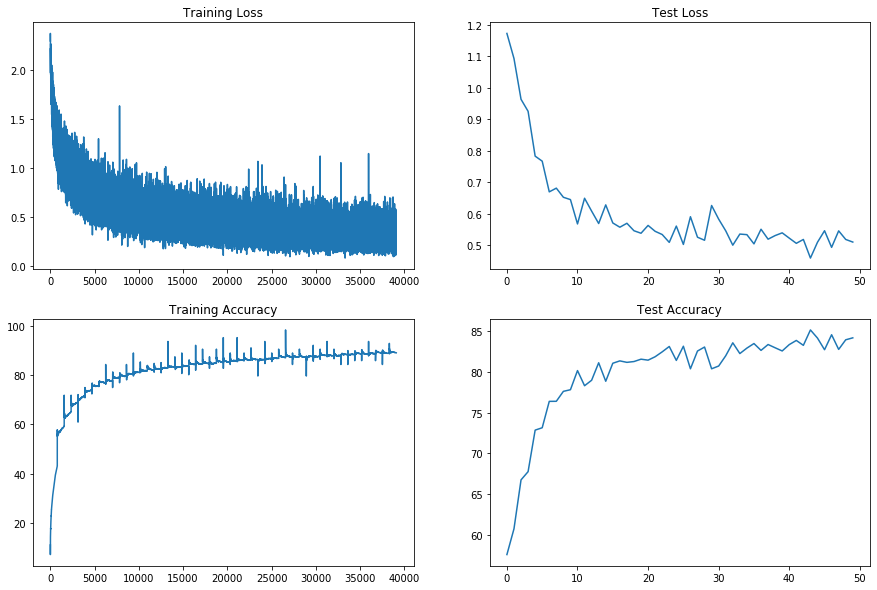

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")